In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
import matplotlib
import re
from datetime import datetime
from wordcloud import WordCloud 
import jieba
import jieba.analyse
from datetime import date
import re
import string
from wordcloud import WordCloud 

### 前處理

In [2]:
df_ = pd.read_csv('./實習心得_detail.csv')
df_.drop('Unnamed: 0', axis=1,inplace=True)
print(df_.shape)

(3494, 8)


In [3]:
df_ = df_[~df_['content'].isna()].reset_index(drop='index')

In [3]:
text = df_.loc[5,'content']
text

'「行銷火星人計畫」暨企業實習。 顛覆你對商學理論的想像。 #企業五管技能。 完全創新的 #行銷實習。 https://lihi3.cc/C57gb。 ———————————————。 南山人壽順橙通訊處112年 「行銷火星人計畫」暨企業實習。 實習主軸:。 行銷火星人計畫概念:。 「價值行銷與策略管理」:傳授最新趨勢行銷學，讓你的行銷有價值也有策略。。 「市場調查與專案管理」:利用市調工具剖析，運用專案管理的方式贏得難搞市場。。 「基礎金融理財管理」:運用金融基礎知識打底，分析各種理財策略下的決策。。 「內容營銷與社交媒體管理」:製定社交媒體策略、創建社交媒體內容，以及如何測量社交媒體營銷效果，並且創建有價值的內容來吸引受眾的行銷方法。。 「社會貢獻與公益活動」:回饋社會，成為愛的傳遞者。。 實習行程表:。 112/06/28~112/08/31。 選修「10堂行銷訓練課程」 時間:週一到週五08:30-11:00。 必修「6堂行銷火星人課程」時間:週四下午14:00-17:00。 必修「高階經理人講座」時間:詳請待七月公告。 必修「火星人培育計畫」:詳請待七月公告。 必修「實習結業典禮」時間:9/7週四。 學生參加條件:。 18歲以上在學學生，四人一組，可自行組隊，亦可由本公司協助分配組隊。。 報名保證金:。 1.個人報名:1,000/人 2.小組報名:1,000/4人 保證金退還方式:達成出席規則標準。 詳情 請洽 王華欣 經理。 Line ID：whhsin。 手機：0919079312。 (注意)實習有獎學金、競賽獎金及可以有實習學分。 往年因每一屆的實習生皆有北中南大學，平均一屆約50-90人，報名人數眾多，因人數有限，需要面試，預計五月會全數面試完畢，月底會公布正式名單。 報名網址。 https://lihi3.cc/C57gb'

In [4]:
def preprocess(text):
    mail_pattern = re.compile(r'\S+@\S+')
    tmp_text = mail_pattern.sub('', text)
    url_pattern = re.compile(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+')
    nourl_text = url_pattern.sub('', tmp_text)
    nourl_text = re.sub(r'\u3000', '。', nourl_text)
    nourl_text = re.sub(r'\U000e0020\U000e0020', '。', nourl_text)
    chiness_pattern = re.compile(r'[\u4e00-\u9fa5a-zA-Z0-9.，。]+')
    first_text = ' '.join(chiness_pattern.findall(nourl_text))
    return first_text

In [16]:
segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
def sentence_segmentation(df, target_column, segment_symboles=[]):
    regexPattern = '['+'|'.join(segment_symboles)+']'
    sentenceCheckRegexPattern = '[,|.| |\t|\n]'

    result = []
    
    for row_dict in df.to_dict(orient="records"):
        sentences = re.split(regexPattern, row_dict[target_column])
        count = 1
        for sent in sentences:
            if re.sub(sentenceCheckRegexPattern, "", sent):
                temp = row_dict.copy()
                del temp[target_column]
                temp["sentence_idx"] = str(count)
                temp["sentence"] = sent
                result.append(temp)
                count +=1
    df = pd.DataFrame(result)
    return df

In [54]:
df_['content'] = df_['content'].apply(lambda x : preprocess(x))

In [17]:
df_.shape

(3488, 8)

In [63]:
df_sen = sentence_segmentation(df_,'content',list(segmentation_used_note))

In [65]:
len(df_sen.groupby('Url', sort=False)['sentence'].apply(list).tolist())

3488

In [18]:
df_sen = sentence_segmentation(df_,'content',list(segmentation_used_note))
df_['sentences'] = df_sen.groupby('Url', sort=False)['sentence'].apply(list).tolist()

In [19]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
#新增自定義字典
jieba.load_userdict('./dict/user_dict.txt')
#新增stop words
#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from c:\D\中山\31lab\裕隆日產\dict\dict.txt.big ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.u8f690af6935baf7001a90ebf9d4408ff.cache
Loading model cost 2.152 seconds.
Prefix dict has been built succesfully.


In [20]:
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w) > 1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [21]:
df_sen['word'] =df_sen.sentence.apply(getToken)
# df_sen = df_sen.explode('word') # 將word欄位展開
df_sen

,date,Url,reaction_like_count,comment_num,poster,posterUrl,comments,sentence_idx,sentence,word
0,2023-05-08,https://mbasic.facebook.com/groups/84929956857...,3,0,謝雅筑,https://mbasic.facebook.com/alayamy?eav=Afbqza...,NaN,1,【實習】Adecco Group 藝珂集團旗下 Spring Professional 躍科...,"[實習, Adecco, Group, 藝珂, 集團, 旗下, Spring, Profes..."
1,2023-05-08,https://mbasic.facebook.com/groups/84929956857...,3,0,謝雅筑,https://mbasic.facebook.com/alayamy?eav=Afbqza...,NaN,2,瑞士商藝珂人事是全世界最大且唯一列入富比士500大企業的人事顧問公司，旗下子品牌 #躍科人才...,"[瑞士, 商藝, 人事, 全世界, 唯一, 列入, 富比, 500, 企業, 人事, 顧問公..."
2,2023-05-08,https://mbasic.facebook.com/groups/84929956857...,3,0,謝雅筑,https://mbasic.facebook.com/alayamy?eav=Afbqza...,NaN,3,我們部門專注在 #軟體領域人才招募 ，包含軟體工程師、資料科學家、PM、設計師等，致力提供企...,"[部門, 專注, 軟體, 領域, 人才, 招募, 包含, 軟體, 工程師, 資料, 科學家,..."
3,2023-05-08,https://mbasic.facebook.com/groups/84929956857...,3,0,謝雅筑,https://mbasic.facebook.com/alayamy?eav=Afbqza...,NaN,4,如果你對 #商務開發、#科技產業 充滿熱情，並希望透過實習獲得實戰經驗，歡迎加入我們，與我們...,"[商務, 開發, 科技產業, 充滿熱情, 希望, 透過, 實習, 實戰經驗, 壯大, 台灣,..."
4,2023-05-08,https://mbasic.facebook.com/groups/84929956857...,3,0,謝雅筑,https://mbasic.facebook.com/alayamy?eav=Afbqza...,NaN,5,【薪資待遇】時薪$176,"[薪資, 待遇, 時薪, 176]"
...,...,...,...,...,...,...,...,...,...,...
48776,2018-12-26,https://mbasic.facebook.com/groups/84929956857...,10,0,Waikei Fong,https://mbasic.facebook.com/vicky.feng.501?eav...,NaN,4,問卷連結：https://www.surveycake.com/s/0lRaN,"[問卷, 連結, https, www, surveycake, com, 0lRaN]"
48777,2018-12-26,https://mbasic.facebook.com/groups/84929956857...,10,0,Waikei Fong,https://mbasic.facebook.com/vicky.feng.501?eav...,NaN,5,獎品：小米手環2＊1＋行動電源＊2 能否順利畢業就靠你們了～,"[獎品, 小米, 手環, 電源, 順利, 畢業]"
48778,2018-12-26,https://mbasic.facebook.com/groups/84929956857...,10,0,Waikei Fong,https://mbasic.facebook.com/vicky.feng.501?eav...,NaN,6,祝大家期末all pass，找工作順利，感謝你們～ 不合版規請告知，會刪,"[期末, all, pass, 工作, 順利, 感謝, 不合, 版規, 告知]"
48779,2018-12-25,https://mbasic.facebook.com/groups/84929956857...,1,0,Elaine Ma,https://mbasic.facebook.com/profile.php?id=100...,NaN,1,想西進求學求職,"[想西進, 求學, 求職]"


In [22]:
df_sen = df_sen.explode('word') # 將word欄位展開

In [23]:
ptt_articleFreq_df = pd.DataFrame(df_sen['word'].value_counts())
ptt_articleFreq_df = ptt_articleFreq_df.reset_index()
ptt_articleFreq_df.columns = ['word', 'freq']
ptt_articleFreq_df

,word,freq
0,工作,6214
1,實習,4866
2,https,4228
3,行銷,3003
4,com,2865
...,...,...
36544,美股,1
36545,散戶,1
36546,金雞,1
36547,招想,1


In [24]:
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

In [25]:
stop_word_update = stopWords + ['https','com','in','the','for','with','of','00','000']

In [26]:
for index,sentence in enumerate(df_sen['word']):
    if sentence in stop_word_update:
        df_sen = df_sen[~df_sen['word'].isin([sentence])]
ptt_articleFreq_df = pd.DataFrame(df_sen['word'].value_counts())
ptt_articleFreq_df = ptt_articleFreq_df.reset_index()
ptt_articleFreq_df.columns = ['word', 'freq']
ptt_articleFreq_df

,word,freq
0,工作,6214
1,實習,4866
2,行銷,3003
3,活動,2714
4,公司,2698
...,...,...
36535,TIME,1
36536,48w5tnGx7LbR9EWN7,1
36537,抽到,1
36538,ytalent,1


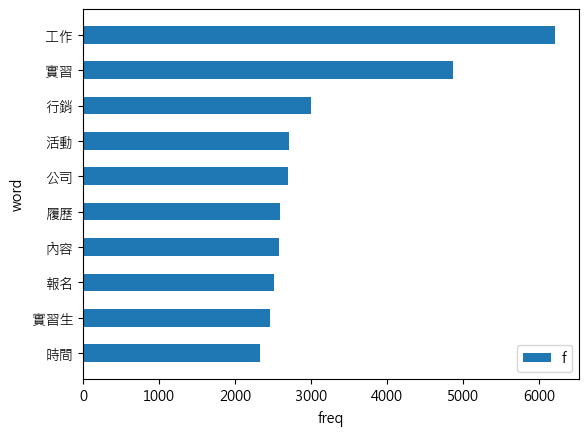

In [27]:
fig, ax = plt.subplots()
tmp = ptt_articleFreq_df['word'][:10]
tmpR = [tmp[i] for i in range(len(tmp)-1,-1,-1)]
ax.barh(tmpR,
        sorted(ptt_articleFreq_df['freq'][:10]), 
        height=0.5, 
        align='center',
        label='freq')
ax.set_ylabel('word')
ax.set_xlabel('freq')
ax.legend('freq', loc ='lower right') 

<Figure size 640x480 with 0 Axes>

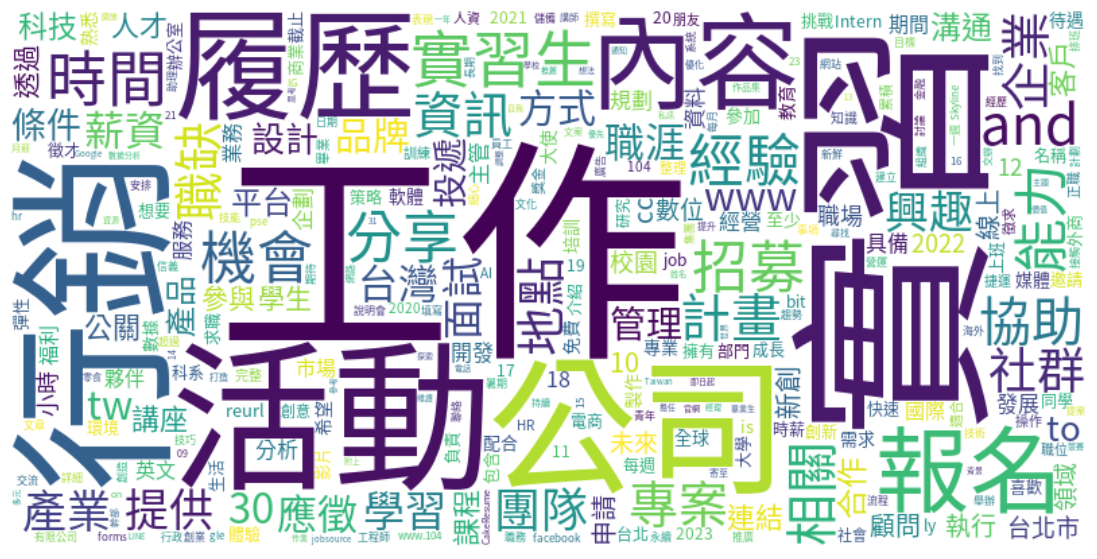

In [28]:
# Generate a word cloud image
font_path = './SourceHanSansTW-Regular.otf'
cloud = WordCloud(max_words=300, background_color="white",width=800, height = 400, font_path=font_path, colormap='viridis')
cloud.generate_from_frequencies({w[1]['word'] : int(w[1]['freq']) for w in ptt_articleFreq_df.iterrows()})
# 繪圖
plt.figure()
plt.figure(figsize=(14,7))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 構面字典

In [4]:
dict_ = pd.read_csv('構面字典-new.csv')
dict_['alias'] = dict_['alias'].apply(lambda x : x.split("|"))
dict_cate = pd.DataFrame(dict_.groupby("class", sort=False)['alias'].apply(lambda x:np.concatenate(list(x))).reset_index())
dict_cate = dict_cate.reset_index()
dict_cate['alias'] = dict_cate['alias'].apply(lambda x : "|".join(x))
dictionary  = dict_cate.set_index("class")["alias"].to_dict()
dictionaryList = list(dictionary.keys())
dictionaryList

['薪資',
 '福利',
 '工時',
 '產品',
 '廣告',
 '人才招募',
 '科系專業',
 '成長價值',
 '經濟報酬',
 '人際價值',
 '組織安全與安定',
 '變化性',
 '產品與服務',
 '公司文化與價值',
 '招募資訊',
 '招募人員',
 '情緒']

#### 公司內外字典

In [5]:
df = df_[(df_.date > '2021-01-01') & (df_.date < '2023-5-6')].reset_index(drop=True)

In [6]:
firm_dict = {
    'in-firm' : '裕隆日產汽車|裕隆汽車|中華汽車|納智捷汽車|鴻華先進|格上租車|裕融企業|Nissan|NISSAN|LUXGEN|Luxgen',
    'out-firm' : '和泰汽車|中華賓士|汎德永業|太古汽車|匯豐汽車|中華汽車|福特六和|台灣本田|鴻華先進|國瑞汽車|三陽工業'
}

In [7]:
df_infirm = df[df.content.str.contains(firm_dict["in-firm"])].reset_index(drop=True)
df_outfirm = df[df.content.str.contains(firm_dict["out-firm"])].reset_index(drop=True)
print(df_infirm.shape)
print(df_outfirm.shape)

(2, 8)
(7, 8)


In [8]:
df_infirm.loc[1,'Url']

'https://mbasic.facebook.com/groups/849299568575237/permalink/2014401552065027/?refid=18&_ft_=encrypted_tracking_data.0AY9lhOohnu3aN1U6b3ZNR2-uelLik1xiYtpg1DrvC-u6YKb6E8uihNWv48C7976-XG1C_XhQTT5vEmOvHaF9y1MwVOW7DhaqEAo72E1qtQ8g3Zg8N6X-kMTgtusskIRU8TW3GkUHKMZhiEIP73mJaqHno8Xfoj9o_Gd6GjQ92WiM2sSG7ZyuqlfDQgZHd3VFAiF2AzNej2wqMiN1noXJY25Gizys0QUShjlj08rjy1YGTdGwwIGSwFcOaNnk-QGUUhKKbtTzvTBf9hm_RYzsLusLlhXLGAWfCuTLU6Ozt9WmK57N2leTnntuVskU9TK52xsQlWgKTg4_K8s4nemY_Tjd-peoBb3zmqIF8-zO7td8X-EcOaT_rj4URIXjvE3cgaZZRDdBbfcQICiO-doK7qa24M5uGnn9DPUI-zAFGOWWGGulkwlG1rXZTH5sWLzlkIEdAXFhKQZOr90eKRNRiuDVnQegeHXHxFuOztyJXDFAKy6NCdFlIv7xPZA-SdmCVxOHQqCqYidvETb9jBPyDa0pnc8_vSsU_dAjbcq3nEmWn4DQlczQTnOa9AD8uYCQef_zpFmQXU6Ro5nD7CHmxo7ZIhdk5ER3ZSa6Bbs4v4gyKdlsU6MtspJ3DzwMZVVat55umuxmDX0MV9Wv_PoL8nhUfq8kWdlnr0qxftAAjeikiBPoHMMnL4bL9O9O3nPeYqS7yBSNqaJNLXSoGyb63sHbwHRc6XWqvzwnySqHC0NcKgpzENlXgQaEMYqNBX0dWmPXGDxkScjZYGCxB8ETdVQS61BDBzp1_gF1BuhkAtyI4K_iFKrM2FVyYfe5UwosoMBsk-8Tp_IpPcw2t0Fu7MnUL3gxBgXKU4c-eaQAFM3CaZi9J

In [122]:
df_infirm.loc[0,'Url']

'https://mbasic.facebook.com/groups/849299568575237/permalink/2296243227214190/?refid=18&_ft_=encrypted_tracking_data.0AY8foJoKDCHC9p7sUXDgyyVFFkV0IeDXiGJL2J4VTjs8tpv2uzZjAFj9QPCWClOUqFkGWX4FA0tLPbSePjDMBni8kTJAznu2-nmYLnFAeZyZfe9mvXhZBpd6ZunO2W07iUrvCndguS62jinqmYYlJU5_4ewUVHSimC0nxGuZK4gqdf_IH03Hb1pjxt6qK0u_l57xzVIA7z1yfla-t2NmwzJ0mCPwaIPLkgXuefXTc79LD4nfGXKn3-BWZjojbsV6468aaKCiGwmo9erVtkxCiewcJjmKFIDVPQCXUY-KWMiz_6CeuYkIZPcwX0_sfD3sX6DqSjERgPhjWf5vEFnW2z15eyqEc_3DYH4g0JSBJrgp7dl0SpvSPHy-78fN5ZOzYLsKAVv8Ccp6TQSKztrQp58x4z0tlJ4T5-SgyF0Hye7D-OfOHk2HMk8DpjBAwOUUOO2oLpLFX7aqU2k3lSSfdCm2zIbyNzwZmVXkslGIkw4iu2riE9-emhYbQN2NXSHdmp_lM5aSYE3cg5DU4uQ9tny_zaJDtHY3SknnGQvz8nuACbEV8trCyGrb8RDW5KiYznZgdV8cBzpfZ0S1vjbuZP8hQC7M1l6E8Xgsd2vNsqdwWKSXTYI_9Rho8Z5ISGj6DP8m_f-y1FCuCEXur1D0R56NC165-HOusGFrRDia2o2itz8cOYSJoWnHF4exa5--NLQdw7dyZf5w26-hOgnS6b0zAlJxOskqtx45Kj890Brlh8hZxm6Cvm2ozCxqrn8UJQj06238snXmO18vsH7zzirw3XGS_RHTt2dJjVzIrIW4lDHS6VRF6LJ1tsTy2rJWeMXVDzKa6M1g5JQwOA9yeaNW_UrapiXxdhJhCJvnnoPf1lZM1

In [117]:
df_outfirm['comment_num'].sum()

1

In [32]:
pd.to_datetime(df_['date']).max()

Timestamp('2023-05-08 00:00:00')

In [34]:
df_[(df_.date > '2020-01-01') & (df_.date < '2020-12-10')].reset_index(drop=True).shape

(562, 9)

In [35]:
df_[(df_.date > '2021-01-01') & (df_.date < '2021-12-10')].reset_index(drop=True).shape

(821, 9)

In [39]:
df_[(df_.date > '2021-01-01') & (df_.date < '2023-5-6')].reset_index(drop=True).shape

(2521, 9)

In [104]:
df_outfirm.to_csv('./實習心得/outfirm.csv', encoding='utf-8-sig')

In [118]:
df_tmp = df_outfirm[~df_outfirm['comments'].isna()]

In [119]:
df_tmp

,date,Url,content,reaction_like_count,comment_num,poster,posterUrl,comments,sentences
6,2021-04-27,https://mbasic.facebook.com/groups/84929956857...,📣和泰汽車2021年暑期實習生📣熱烈招募中🔥。 和泰汽車為TOYOTA、LEXUS、HINO...,26,1,陳正芬,https://mbasic.facebook.com/fanninchen?eav=AfY...,"[{'poster': '范瑞洋', 'posterUrl': 'https://mbasi...","[📣和泰汽車2021年暑期實習生📣熱烈招募中🔥, 和泰汽車為TOYOTA、LEXUS、HI..."


In [60]:
df_outfirm[~df_outfirm['comments'].isna()].loc[12,'Url']

'https://mbasic.facebook.com/groups/849299568575237/permalink/2121072714731243/?refid=18&_ft_=encrypted_tracking_data.0AY_o7evwJAfFkt3N8pB2RmI96S5CTXxBw7TNzFEiP1ZIBC4SahKX_0SC8aQXaJiFSsL6Xvn6X0njGuTs_F1I9ilLIBlA85s5sQrmsT9WZ_3ZrKIgrRrKLUg1Cdusm46BSgi65zJZO6vKs7-RGIC1Q6x6fAHHmrR1wLISsr5uBeOi-ut59oltOmb5f0MENZjb76MvcIiSItDJO8VA0m4WNwOQqErcS5az0sIt7T8TBxXr073EvWr1cN658UmyeuIgs5QUQ11GpkXgcHqQLdaCrEDBDsDHiLJOdipGA2FdijAAb-QeE-Sdb3TkkfGK9qhf6-nA0M47KQc2qwU4bzT5nBf78o0Q43rVWcu1UpMAUJmGudfgoiE3tx06q46pAf7ZvYUQjB7ONESMsbMe3sGXmLVSGgONkNEH5CuDMp_kDHPCZ7bi0R2_0bDJoeNF2gXwCcgqYAPTcPMuAGsLgi5NZIi_V6YN1Tje6C4_YBBhqBvujZ5VWkyMKQNwt7lorXDEXIa-xHoL1DOSjiqwIqFmthO7-49IR5SglzW0cZfxlnZmOvU2KW8d0M8Fm3nFB3MWAjdjsq-gIjGXN2jrAMuiR37IQ-CuZ_RqpAtL7wwHL0_D-v_OoGfN0h38W8Zi62mzv5PtjEBTCgxjqYcPV9v5dc-PXoi98dJd2NWOJX_5lyErhAoF249ujGZrZCmhe_-8uKIsMiYe7QnJs8wyWlCFZvJrb68s_LwtR-ioYbQGbTuKdx0FiBckaegoOE8ZLidmBYdFkiEEf-_jvmj17VnD3LT4VyUcNAOKr-3UqTMzV3JpXJx47fu39bC1K7dLPssEp2mlmob8aAaB1FWp-jazlNcl_d-MG0jN3nijjbXcng5lFGplH

In [30]:
def get_comment(dataList):
    text = []
    dataList = eval(dataList)
    for data in dataList:
        text.append(data['comment'])
    return '。'.join(text)

In [32]:
segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
def comment_segmentation(df, target_column, segment_symboles=[]):
    regexPattern = '['+'|'.join(segment_symboles)+']'
    sentenceCheckRegexPattern = '[,|.| |\t|\n]'

    result = []
    
    for row_dict in df.to_dict(orient="records"):
        sentences = re.split(regexPattern, row_dict[target_column])
        count = 1
        for sent in sentences:
            # if re.sub(sentenceCheckRegexPattern, "", sent):
            temp = row_dict.copy()
            del temp[target_column]
            temp["comment_idx"] = str(count)
            temp["comment"] = sent
            result.append(temp)
            count +=1
    df = pd.DataFrame(result)
    return df

In [31]:
df_comment = df_[~df_['comments'].isna()]
df_comment.reset_index(drop='index',inplace=True)

In [34]:
df_comment['comments_text'] = df_comment['comments'].apply(lambda x : get_comment(x))

c:\Users\User\anaconda3\envs\text_\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
df_comment_s = comment_segmentation(df_comment,'comments_text',list(segmentation_used_note))
df_comment['comment'] = df_comment_s.groupby('Url', sort=False)['comment'].apply(list).tolist()


c:\Users\User\anaconda3\envs\text_\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [49]:
df_comment_s = df_comment_s[df_comment_s['comment']!='']
df_comment_s.reset_index(drop='index',inplace=True)

In [53]:
df_comment_s['word'] =df_comment_s.comment.apply(getToken)
df_comment_s = df_comment_s.explode('word') # 將word欄位展開
df_comment_s.head()

,date,Url,content,reaction_like_count,comment_num,poster,posterUrl,comments,sentences,comment,comment_idx,word
0,2023-05-08,https://mbasic.facebook.com/groups/84929956857...,哈囉大家好！我是 Yourator 的實習生 Fiona 今天想和大家分享 🚀#Yourat...,3,2,鄭舫,https://mbasic.facebook.com/profile.php?id=100...,"[{'poster': '李承洋', 'posterUrl': 'https://mbasi...","[哈囉大家好, 我是 Yourator 的實習生 Fiona 今天想和大家分享 🚀#Your...",推,1,NaN
1,2023-05-08,https://mbasic.facebook.com/groups/84929956857...,哈囉大家好！我是 Yourator 的實習生 Fiona 今天想和大家分享 🚀#Yourat...,3,2,鄭舫,https://mbasic.facebook.com/profile.php?id=100...,"[{'poster': '李承洋', 'posterUrl': 'https://mbasi...","[哈囉大家好, 我是 Yourator 的實習生 Fiona 今天想和大家分享 🚀#Your...",推推,2,推推
2,2023-05-01,https://mbasic.facebook.com/groups/84929956857...,【NGO實習】 #NGO實習 #地方創生 #internship #實習單位：社團法人新竹縣...,4,3,Ja Hsu,https://mbasic.facebook.com/ja.hsu1?eav=AfZa0f...,"[{'poster': '李博華', 'posterUrl': 'https://mbasi...",[【NGO實習】 #NGO實習 #地方創生 #internship #實習單位：社團法人新竹...,推個老闆人很好,1,推個
2,2023-05-01,https://mbasic.facebook.com/groups/84929956857...,【NGO實習】 #NGO實習 #地方創生 #internship #實習單位：社團法人新竹縣...,4,3,Ja Hsu,https://mbasic.facebook.com/ja.hsu1?eav=AfZa0f...,"[{'poster': '李博華', 'posterUrl': 'https://mbasi...",[【NGO實習】 #NGO實習 #地方創生 #internship #實習單位：社團法人新竹...,推個老闆人很好,1,老闆
3,2023-05-01,https://mbasic.facebook.com/groups/84929956857...,【NGO實習】 #NGO實習 #地方創生 #internship #實習單位：社團法人新竹縣...,4,3,Ja Hsu,https://mbasic.facebook.com/ja.hsu1?eav=AfZa0f...,"[{'poster': '李博華', 'posterUrl': 'https://mbasi...",[【NGO實習】 #NGO實習 #地方創生 #internship #實習單位：社團法人新竹...,Yu Rou Wu,3,Yu


In [54]:
ptt_commentFreq_df = pd.DataFrame(df_comment_s['word'].value_counts())
ptt_commentFreq_df = ptt_commentFreq_df.reset_index()
ptt_commentFreq_df.columns = ['word', 'freq']
ptt_commentFreq_df

,word,freq
0,推推,358
1,https,127
2,com,73
3,實習,70
4,報名,63
...,...,...
2759,ENS,1
2760,師範學校,1
2761,高等,1
2762,薩克雷,1


In [55]:
stop_word_update = stopWords + ['https','com','www','and','to','in','the','for','with','of','00','000']
for index,token in enumerate(df_comment_s['word']):
    if token in stop_word_update:
        df_comment_s = df_comment_s[~df_comment_s['word'].isin([token])]
ptt_commentFreq_df = pd.DataFrame(df_comment_s['word'].value_counts())
ptt_commentFreq_df = ptt_commentFreq_df.reset_index()
ptt_commentFreq_df.columns = ['word', 'freq']
ptt_commentFreq_df

,word,freq
0,推推,358
1,實習,70
2,報名,63
3,履歷,57
4,興趣,46
...,...,...
2753,ENS,1
2754,師範學校,1
2755,高等,1
2756,薩克雷,1


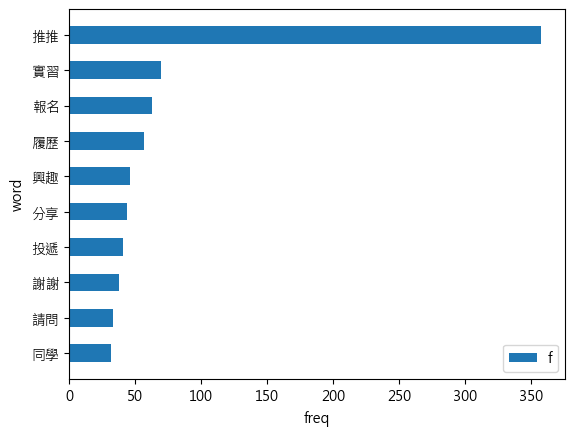

In [56]:
fig, ax = plt.subplots()
tmp = ptt_commentFreq_df['word'][:10]
tmpR = [tmp[i] for i in range(len(tmp)-1,-1,-1)]
ax.barh(tmpR,
        sorted(ptt_commentFreq_df['freq'][:10]), 
        height=0.5, 
        align='center',
        label='freq')
ax.set_ylabel('word')
ax.set_xlabel('freq')
ax.legend('freq', loc ='lower right') 

<Figure size 640x480 with 0 Axes>

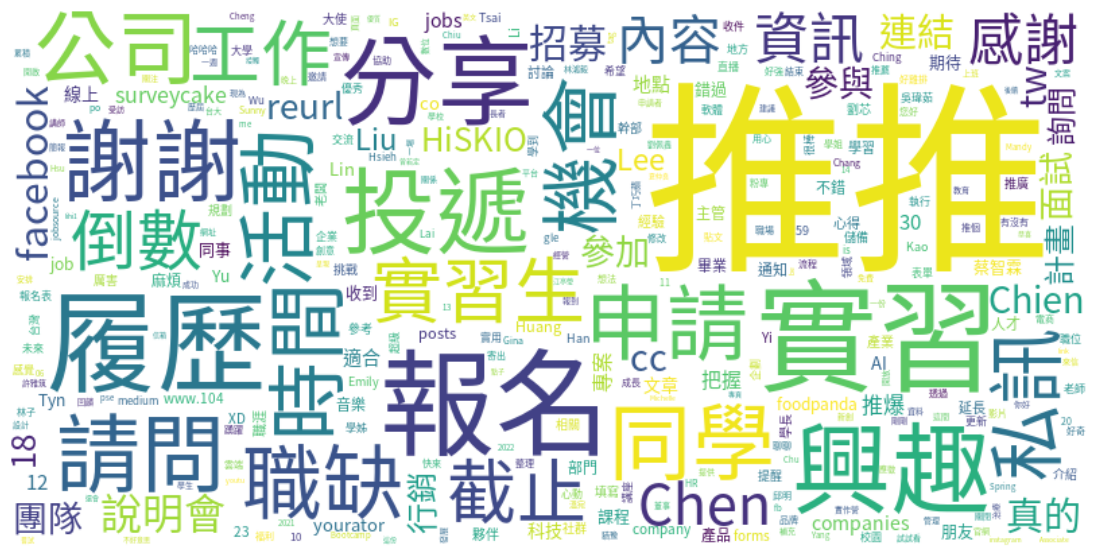

In [57]:
# Generate a word cloud image
font_path = './SourceHanSansTW-Regular.otf'
cloud = WordCloud(max_words=300, background_color="white",width=800, height = 400, font_path=font_path, colormap='viridis')
cloud.generate_from_frequencies({w[1]['word'] : int(w[1]['freq']) for w in ptt_commentFreq_df.iterrows()})
# 繪圖
plt.figure()
plt.figure(figsize=(14,7))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()